<a href="https://colab.research.google.com/github/AURORARISE/MSSP-6070/blob/main/week8_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [22]:
csv_path = Path("/content/drive/MyDrive/MSSP6070/c. Modules/Week_8/InternetSales.csv")

In [23]:
output_dir = Path("/content/drive/MyDrive/MSSP6070/c. Modules/Week_8/outputs")
output_dir.mkdir(parents=True, exist_ok=True)

In [24]:
encodings = ["utf-8", "latin-1", "utf-16", "cp1252"]
df = None
for enc in encodings:
    try:
        df = pd.read_csv(csv_path, encoding=enc, engine="python")
        break
    except Exception:
        continue
if df is None:
    raise RuntimeError("Unable to read CSV, please check the path or encoding.")


In [25]:
print("File read successful, the first few lines are as follows:")
print(df.head())

File read successful, the first few lines are as follows:
   ID  CustomerKey  GeographyKey         City CountryRegionCode  \
0   0        11000            26  Rockhampton                AU   
1   1        11000            26  Rockhampton                AU   
2   2        11000            26  Rockhampton                AU   
3   3        11000            26  Rockhampton                AU   
4   4        11000            26  Rockhampton                AU   

  EnglishCountryRegionName CustomerAlternateKey Title FirstName MiddleName  \
0                Australia           AW00011000   NaN       Jon          V   
1                Australia           AW00011000   NaN       Jon          V   
2                Australia           AW00011000   NaN       Jon          V   
3                Australia           AW00011000   NaN       Jon          V   
4                Australia           AW00011000   NaN       Jon          V   

   ... ProductStandardCost  TotalProductCost SalesAmount    TaxAmt  Fr

In [26]:
def find_date_column(columns):
    candidates = ["OrderDate", "Order Date", "Date", "InvoiceDate", "OrderDateKey"]
    dynamic = [c for c in columns if "date" in c.lower()]
    for name in candidates + dynamic:
        if name in columns:
            return name
    return None

def find_sales_column(columns):
    priority = ["Sales", "Sale", "SalesAmount", "Sales Amount", "Revenue", "Amount", "Total", "LineTotal"]
    dynamic = [c for c in columns if any(k in c.lower() for k in ["sale", "revenue", "amount", "total"])]
    for name in priority + dynamic:
        if name in columns:
            return name
    return None

def find_product_column(columns):
    priority = ["Product", "ProductName", "Product Name", "Item", "ItemName", "SKU", "Model"]
    dynamic = [c for c in columns if any(k in c.lower() for k in ["product", "item", "model", "sku"])]
    for name in priority + dynamic:
        if name in columns:
            return name
    return None

date_col = find_date_column(df.columns)
sales_col = find_sales_column(df.columns)
product_col = find_product_column(df.columns)

In [27]:
print(f"Date column: {date_col}")
print(f"Sales revenue column: {sales_col}")
print(f"Product Column: {product_col}")
if date_col is None or sales_col is None:
    raise RuntimeError("Please check the file, unable to recognize the date or sales column.")

Date column: OrderDate
Sales revenue column: SalesAmount
Product Column: ProductKey


In [28]:
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col])
df[sales_col] = pd.to_numeric(df[sales_col], errors="coerce")
df = df.dropna(subset=[sales_col])

In [29]:
df["Year"] = df[date_col].dt.year.astype(int)
yearly_sales = (
    df.groupby("Year", as_index=False)[sales_col]
      .sum()
      .rename(columns={sales_col: "Sales"})
      .sort_values("Year")
)
from IPython.display import display
display(yearly_sales.head())


,Year,Sales
0,2010,4.342104e+04
1,2011,7.075526e+06
2,2012,5.842485e+06
3,2013,1.635155e+07
4,2014,4.569472e+04


In [30]:
all_years = pd.DataFrame({"Year": np.arange(yearly_sales["Year"].min(), yearly_sales["Year"].max() + 1)})
ys_full = all_years.merge(yearly_sales, on="Year", how="left")
ys_full["Sales"] = ys_full["Sales"].interpolate(limit_direction="both")
ts = ys_full.set_index("Year")["Sales"].astype(float)


Five-year forecast：


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Year,Forecast
0,2015,1.039710e+07
1,2016,1.212005e+07
2,2017,1.384299e+07
3,2018,1.556593e+07
4,2019,1.728887e+07


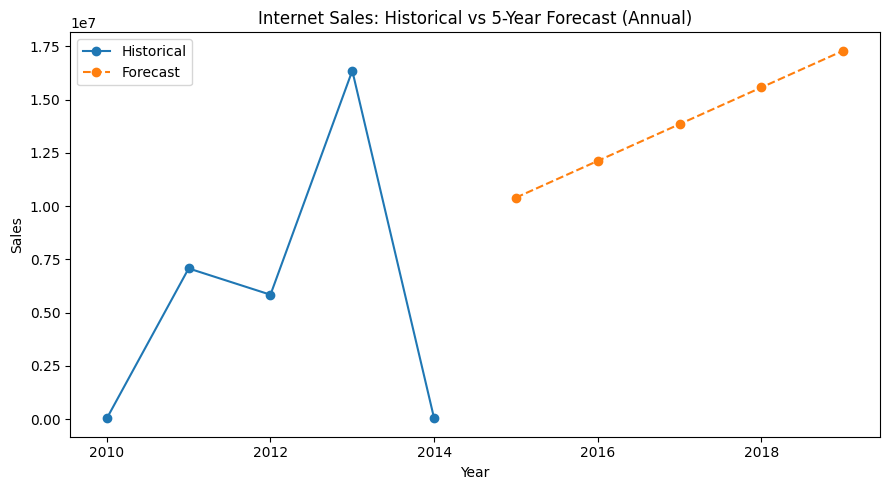

In [31]:
if len(ts) < 3:
    x = np.arange(len(ts))
    coef = np.polyfit(x, ts.values, 1)
    forecast_idx = np.arange(len(ts), len(ts) + 5)
    forecast_vals = pd.Series(coef[0]*forecast_idx + coef[1], index=np.arange(ts.index.max()+1, ts.index.max()+6))
else:
    model = ExponentialSmoothing(ts, trend="add", seasonal=None)
    fit = model.fit(optimized=True)
    forecast_vals = fit.forecast(5).clip(lower=0)

forecast_df = pd.DataFrame({
    "Year": np.arange(ts.index.max()+1, ts.index.max()+6),
    "Forecast": forecast_vals.values
})
print("\nFive-year forecast：")
display(forecast_df)
plt.figure(figsize=(9,5))
plt.plot(ts.index, ts.values, marker="o", label="Historical")
plt.plot(forecast_df["Year"], forecast_df["Forecast"], marker="o", linestyle="--", label="Forecast")
plt.title("Internet Sales: Historical vs 5-Year Forecast (Annual)")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
plot_path = output_dir / "Internet_Sales_Forecast_Plot.png"
plt.savefig(plot_path)
print(f"The image has also been saved: {plot_path}")

The image has also been saved: /content/drive/MyDrive/MSSP6070/c. Modules/Week_8/outputs/Internet_Sales_Forecast_Plot.png


<Figure size 640x480 with 0 Axes>

In [33]:
if product_col is not None:
    product_summary = (
        df.groupby(product_col)[sales_col]
          .agg(Total_Sales="sum", Mean_Sales="mean", Median_Sales="median", Count="count")
          .sort_values("Total_Sales", ascending=False)
          .reset_index()
    )
    print("\nThe highest selling product:")
    display(product_summary.head(5))
else:
    print("\nProduct column not found, skip product analysis.")

print("\nAll analyses have been completed.")


The highest selling product:


,ProductKey,Total_Sales,Mean_Sales,Median_Sales,Count
0,312,1205876.99,3578.27,3578.27,337
1,310,1202298.72,3578.27,3578.27,336
2,313,1080637.54,3578.27,3578.27,302
3,314,1055589.65,3578.27,3578.27,295
4,311,1005493.87,3578.27,3578.27,281



All analyses have been completed.
